<a href="https://colab.research.google.com/github/gabriellopera/Lab-5/blob/master/FinalProject_TS3_RadioML_20232_EG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

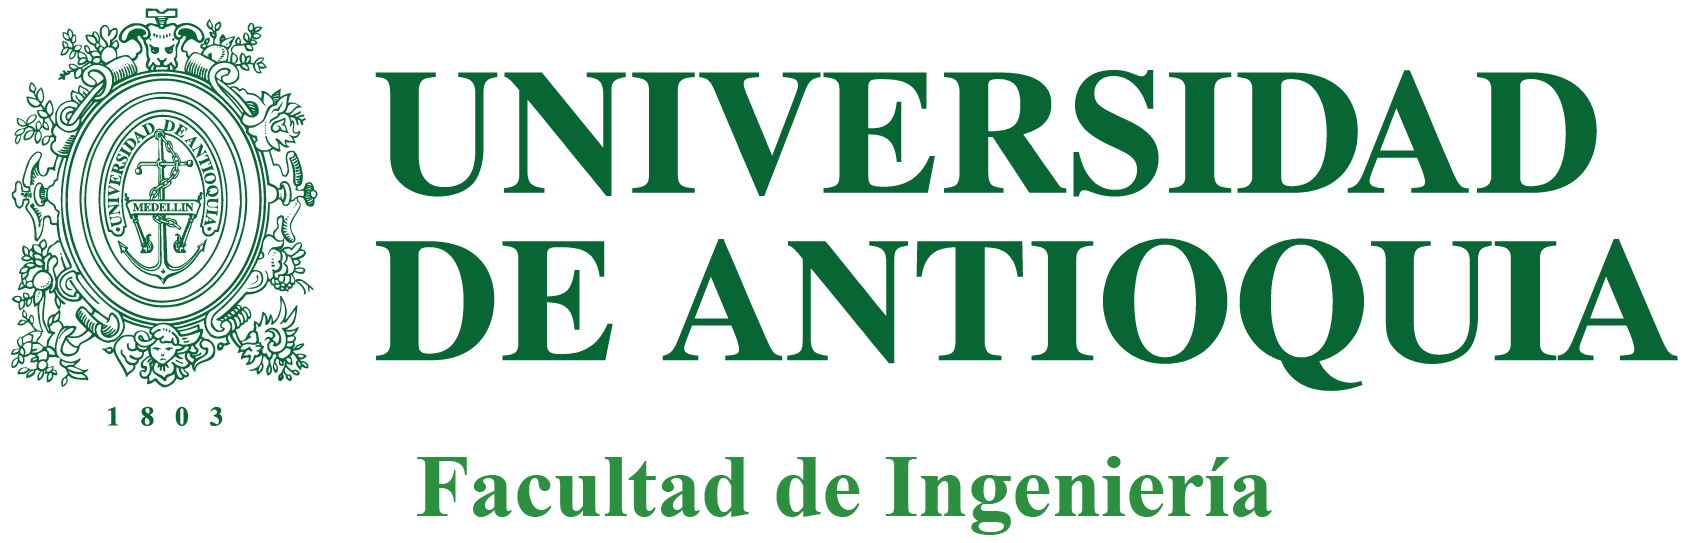
---
- **Asignatura:** Tratamiento de Señales III
- **Profesor:** Hernán Felipe García Arias
- **Integrantes:** Andrés Escalante, Gabriel Lopera Madrid
- **Ingeniería de Telecomunicaciones**
- **UdeA**
- **2023-2**

---

## Reconocimiento de modulación: conjunto de datos Radio Machine Learning 2016.10a

More information on this classification method can be found at
https://arxiv.org/abs/1602.04105

More information on the RML2016.10a dataset can be found at
http://pubs.gnuradio.org/index.php/grcon/article/view/11

Please cite derivative works

```
@article{convnetmodrec,
  title={Convolutional Radio Modulation Recognition Networks},
  author={O'Shea, Timothy J and Corgan, Johnathan and Clancy, T. Charles},
  journal={arXiv preprint arXiv:1602.04105},
  year={2016}
}
@article{rml_datasets,
  title={Radio Machine Learning Dataset Generation with GNU Radio},
  author={O'Shea, Timothy J and West, Nathan},
  journal={Proceedings of the 6th GNU Radio Conference},
  year={2016}
}
```

Para ejecutar este ejemplo, deberá descargar o generar el conjunto de datos RML2016.10a (https://radioml.com/datasets/)
También necesitarás Keras instalado con el backend de Theano o Tensor Flow funcionando!

In [ ]:
!gdown '1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K'

Downloading...
From: https://drive.google.com/uc?id=1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K
To: /content/RML2016.10a_dict.pkl
100% 641M/641M [00:04<00:00, 134MB/s]


In [ ]:
import os,random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, sys
from sklearn.metrics import classification_report


### LIBRERÍAS KERAS ###
from tensorflow import keras
from keras.utils import to_categorical
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *

%matplotlib inline

## Keras
[Keras](https://keras.io/) es una abstracción de Python que le permite definir una red neuronal y codificarla automáticamente para bibliotecas de aprendizaje profundo (actualmente DeepLearning4j, TensorFlow y Theano). Simplemente le dice a Keras cuántas capas hay en el modelo de red y define cómo se ven esas capas. Keras se encarga de convertirlo en algo que TensorFlow y Theano puedan usar. Por lo tanto, es excelente para la experimentación de desarrollo rápido con redes neuronales. Puede construir cosas rápidamente y modificar rápidamente redes neuronales.

# Configuración del conjunto de datos

O'Shea, Corgan y Clancy generaron un conjunto de datos simulados utilizando [GNU Radio](http://gnuradio.org). Se guarda como un archivo Pickle. Es solo un archivo binario que se puede leer en Python (es un diccionario, similar a un archivo JSON).

Hay otros archivos de datos que puede utilizar para entrenar y probar el modelo en el sitio web [radioml.com](https://radioml.com/datasets/radioml-2016-10-dataset/). El archivo Python para crear el conjunto de datos está [aquí](https://github.com/radioML/dataset/blob/master/generate_RML2016.10a.py).

In [ ]:
# Load the dataset ...
#  You will need to seperately download (radioml.com) or generate this file
with open("RML2016.10a_dict.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding="latin1")

## Formato de pepinillo

Los datos que se guardaron contenían una gran matriz de diccionario de Python. Las claves del diccionario fueron las combinaciones de tipo de [modulación](https://en.wikipedia.org/wiki/Phase-shift_keying) y relaciones señal-ruido (SNR) que fueron simuladas por GNU Radio para producir los datos. Hay 11 esquemas de modulación: 8 digitales y 3 analógicos. Se añadió ruido blanco gaussiano a cada señal proporcional a la potencia de la señal.

Por ejemplo, se simuló una señal [modulada por BPSK] (https://en.wikipedia.org/wiki/Phase-shift_keying#Binary_phase-shift_keying_.28BPSK.29) con SNR de -20 dB, -18 dB, -16 dB. , hasta 18 dB. Para una SNR de 0, la señal BPSK tendría la misma potencia total que el ruido gaussiano. Para SNR inferiores a 0, la señal BPSK se vería inundada por el ruido. En otras palabras, sería imposible para un humano identificar la modulación de esas SNR.

$$ \text{SNR in decibels} = 10 \times \log \left ( \frac{\text{signal power}}{\text{noise power}} \right ) $$

In [ ]:
# Calculate modulations and signal-to-noise ratios contained in dataset
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
print('These are the modulation schemes in the dataset: {}'.format(mods))
print('These are the signal to noise ratios in the dataset: {}'.format(snrs))
print('SNRs total',len(snrs))

These are the modulation schemes in the dataset: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
These are the signal to noise ratios in the dataset: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
SNRs total 20


### Señales de radiofrecuencia (RF)

Una vez que hayamos especificado la clave del diccionario (por ejemplo, ['QAM64', 4] para modulación QAM64 a 4 dB SNR), nos quedará la siguiente matriz.

In [ ]:
np.shape(Xd['BPSK', -18])

(1000, 2, 128)

+ La segunda dimensión representa los dos componentes (I y Q) de la señal de RF.
+ La tercera dimensión representa las 128 muestras en el tiempo (1 MHz, es decir, 1 μs por índice).
+ La primera dimensión representa las 1000 ventanas muestreadas (cada ventana tiene las 128 muestras I y Q)

# Please help me correct this. I am not sure if I am calculating the raw signal correctly.

$$\text{Modulated Carrier RF} = I \cos(2\pi ft) + Q \sin(2 \pi ft)$$

In [ ]:
'''
Compute the original RF signal from the I & Q components.
'''
def reconstructSignal(s):
    I = s[0,:]   # I component
    Q = s[1,:]   # Q component
    n = len(I)   # number of samples
    f = 1e6     # Carrier frequency
    return I*np.cos(2*np.pi*f*np.arange(n)) + Q*np.sin(2*np.pi*f*np.arange(n))

## Tracemos algunos de los datos sin procesar.

Así que elegiremos un 8PSK (con SNR @ 18 dB), un PAM4 (con SNR @ 6 dB), un BPSK (con SNR @ 0 dB) y un QAM64 (con SNR @ -12 dB).

Observe cómo la señal queda enterrada en el ruido a medida que disminuye la SNR.

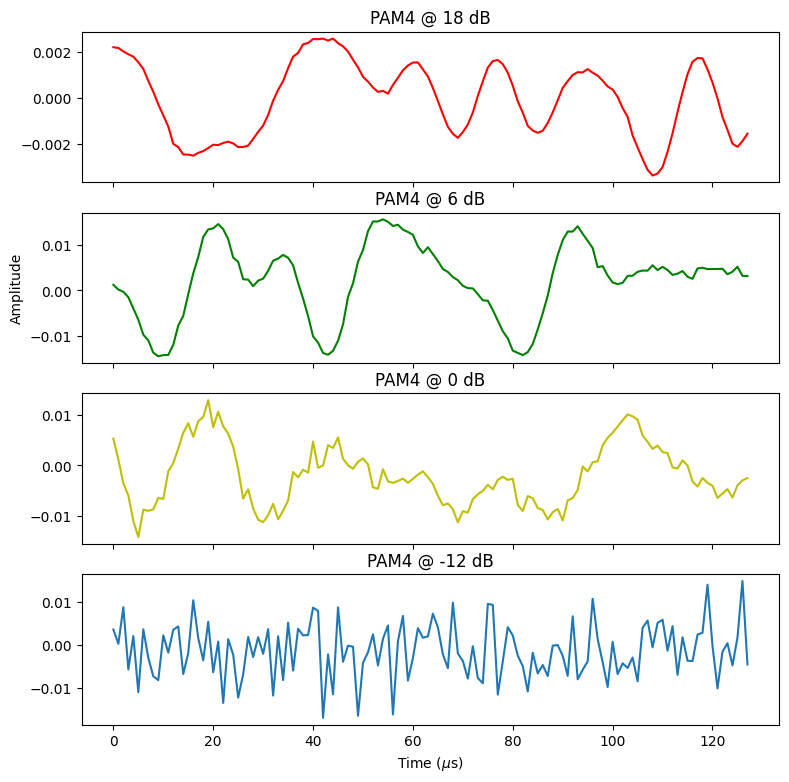

In [ ]:
# Plot some of the data
nFigs = 4

plt.figure(figsize=(9, 9))

ax1 = plt.subplot(nFigs, 1, 1);
plt.plot(reconstructSignal(Xd['PAM4', 16][2,:,:]), color='r');
plt.title('PAM4 @ 18 dB')

ax2 = plt.subplot(nFigs, 1, 2, sharex=ax1);
plt.plot(reconstructSignal(Xd['PAM4', 4][99,:,:]), color='g');
plt.title('PAM4 @ 6 dB')

plt.ylabel('Amplitude');

ax3 = plt.subplot(nFigs, 1, 3, sharex=ax1)
plt.plot(reconstructSignal(Xd['PAM4', 0][456,:,:]), color='y');
plt.title('PAM4 @ 0 dB')

ax4 = plt.subplot(nFigs, 1, 4, sharex=ax1)
plt.plot(reconstructSignal(Xd['PAM4', -12][32,:,:]));
plt.title('PAM4 @ -12 dB')

# We only need to show the xticks on the bottom subplot
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.xlabel(r'Time ($\mu$s)');

## Ahora necesitamos agregar toda la modulación, SNR, muestras, canales y puntos de tiempo en una gran matriz para pasar a nuestra red neuronal.

Entonces habrá 220.000 muestras. Cada muestra es de 2 x 128. Los 2 son los canales I y Q. Las 128 son las 128 muestras de tiempo de la forma de onda (muestreadas a 1 MHz).

In [ ]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [ ]:
np.shape(X)

(220000, 2, 128)

## Agregar clase de ruido al conjunto de datos

Entonces, agreguemos 2 canales de ruido gaussiano aleatorio para ver si podemos darle a la red la opción de elegir si no puede decidir entre las modulaciones verdaderas. Esta es básicamente una clasificación de "No sé".

In [ ]:
numNoiseSamples = 20000 # Add 20,000 samples of just Gaussian noise
for i in range(numNoiseSamples):
    lbl.append(['Noise', snrs[i%len(snrs)]])

mods.append('Noise')
X_noise = np.random.normal(0, 0.01, [numNoiseSamples, 2, 128])
X = np.concatenate((X, X_noise))  # Add noise to the end of the data

### Ahora dividamos aleatoriamente el conjunto de datos en un grupo de entrenamiento y un grupo de prueba.

El grupo de entrenamiento se utilizará para calcular los pesos de la red neuronal. El grupo de prueba se utilizará para evaluar (validar) qué tan bien se generalizan esos pesos a nuevos datos (es decir, qué tan bien debería funcionar nuestra red neuronal en la naturaleza).

Nuestro primer paso es [One Hot Encode](https://en.wikipedia.org/wiki/One-hot). Suena mal, pero es un procedimiento realmente sencillo. Básicamente, la computadora no entiende letras; sólo puede utilizar números. Por lo tanto, no tiene idea de a qué se refieren '8PSK' o 'WBFM' y no tiene forma de entrenar un modelo para que se ajuste a esas etiquetas. Ahora podríamos simplemente asignar un número a cada modulación (por ejemplo, 1 = '8PSK', 2 = 'AM-DSB', 3 = 'PAM4', etc.). Sin embargo, la codificación one-hot nos facilita calcular qué tan cerca está la salida de nuestra red neuronal (es decir, la predicción) del valor verdadero (esperado).

Para la codificación one-hot simplemente declaramos un vector que es tan grande como el conjunto de modulaciones únicas. Entonces, si tenemos 11 modulaciones, declaramos un vector de tamaño 1 x 11. La matriz es 0 en todas partes excepto en la modulación que se representa. Por ejemplo,

+  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] codes '8PSK'
+  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] codes 'AM-DSB'
+  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] codes 'WBFM'
  
Entonces, el elemento más a la izquierda codifica '8PSK' y el más a la derecha codifica 'WBFM'. El posicionamiento es arbitrario. Simplemente tiene que aplicarse de forma coherente al conjunto de datos.

Una vez que hayamos codificado One Hot, podremos comparar qué tan cerca llega la salida de nuestra red neuronal (es decir, la predicción) a la modulación verdadera. Esta medida de "cercanía" se calcula normalmente mediante entropía cruzada (Shannon). Hay un excelente [video aquí] (https://www.youtube.com/watch?v=tRsSi_sqXjI).

$$ \text{cross entropy} = - \sum_i{L_i \log{S_i}}$$

where
+ $i$ goes from 1 to the number of modulations
+ $L_i$ is the one-hot label for that sample in that modulation
+ $S_i$ is the neural network's prediction for that sample in that modulation

Por ejemplo, si nuestra red neuronal predice 3 clases con las siguientes probabilidades:

$$\begin{bmatrix}0.2\\0.7\\0.1 \end{bmatrix}$$

y la muestra real tiene la codificación one-hot de:

$$\begin{bmatrix}0\\1\\0\end{bmatrix}$$

Then our cross-entropy is:  
$$ - [ 0 \times \log(0.2) + 1 \times \log(0.7) + 0 \times \log(0.1) ] = \log(0.7) = 0.155$$

Si la predicción es perfecta, entonces la entropía cruzada es $1 \times \log(1) = 0$

In [ ]:
from sklearn.preprocessing import LabelBinarizer
#
lbl = np.array(lbl) # Convert from list to numpy array (for speed)
#
# This will encode the labels into a binary array.
# This is referred to as One-Hot.
# Each element of the array is either 1 or 0.
# The position of the element refers to which type of modulation.
# So if there are 11 modulation types, then the
# array is length 11.
# e.g.  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] codes '8PSK'
#       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] codes 'AM-DSB'
#       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] codes 'WBFM'
# We'll use this to compare the output of the neural network
# and help train the model to give the lowest error (in this case
# the cost will be the cross-entropy).
y_encoded = LabelBinarizer().fit_transform(lbl[:,0])
print(y_encoded.shape)
y_encoded[:8]

(240000, 12)


array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

## Dividir en un conjunto de entrenamiento y prueba

Es crucial que dividamos los datos en al menos 2 conjuntos. Se utilizará un conjunto (llamado conjunto de entrenamiento) para entrenar la red neuronal. Es decir, los pesos de la red neuronal se ajustarán para realizar la mejor predicción posible de los datos de entrenamiento. Sin embargo, si nos detuviéramos ahí, entonces tendríamos un modelo que fuera bueno para predecir cosas cuyas respuestas ya conocía. Queremos asegurarnos de que el modelo pueda predecir cosas que nunca antes había visto. Por lo tanto, guardamos algunos datos (generalmente entre 1/4 y 1/3) para probar si la red neuronal entrenada puede ser tan precisa en datos que nunca ha visto.

La mayoría de los kits de herramientas de aprendizaje automático decentes contienen un método para dividir aleatoriamente sus datos en estos dos conjuntos. Normalmente usamos el de sklearn (train_test_split). Sin embargo, queremos realizar un seguimiento de los índices para poder obtener también las SNR al final. Entonces usaremos una matriz aleatoria para dividir los dos grupos.

In [ ]:
# Partition the data
#  into training and test sets of the form we can train/test on
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.7)

# Now get a list of random indicies to sample for the training set
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# Testing set is whatever indicies are left over
test_idx = list(set(range(0,n_examples))-set(train_idx))

# Now split up the data by the random indicies
X_train = X[train_idx]
X_test =  X[test_idx]
Y_train = y_encoded[train_idx]
Y_test = y_encoded[test_idx]

In [ ]:
(X_train, X_valid) = X_train[8000:], X_train[:8000]
(Y_train, Y_valid) = Y_train[8000:], Y_train[:8000]

print('Training set is {}'.format(np.shape(X_train)))
print('Test set is {}'.format(np.shape(X_test)))
print('Test set: {}'.format(np.shape(X_test)))

Training set is (160000, 2, 128)
Test set is (72000, 2, 128)
Test set: (72000, 2, 128)


In [ ]:
in_shp = list(X_train.shape[1:])   # This is the input shape of 2 channels x 128 time samples
print(X_train.shape, in_shp)
classes = mods
print(classes)

(160000, 2, 128) [2, 128]
['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM', 'Noise']


In [ ]:
w, h = 2, 128
X_train = X_train.reshape(X_train.shape[0], w, h, 1)
X_valid = X_valid.reshape(X_valid.shape[0], w, h, 1)
X_test = X_test.reshape(X_test.shape[0], w, h, 1)

Modelo #NN

Su tarea aquí es codificar 2 arquitecturas CNN para evaluar el reconocimiento de modulación utilizando enfoques de aprendizaje profundo.

In [ ]:
# Build CNN Neural Net model using tensorflow  --
#  - Reshape [N,2,128] to [N,2,128,1] on input
#  - Pass through 3 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.6 # dropout rate (%) = percentage of neurons to randomly lose each iteration
classes=12
model = models.Sequential()  # Neural network is a set of sequential layers
#model.add(Convolution2D(...))

model.add(Reshape((w,h,1), input_shape=(w,h)))

model.add(Convolution2D(filters=16, kernel_size=(1,9), padding='same', strides=(1,1), activation='relu', input_shape=(w,h,1)))

model.add(Convolution2D(filters=32, kernel_size=(1,9), padding='same', strides=(1,1), activation='relu'))

model.add(Convolution2D(filters=64, kernel_size=(1,9), padding='same', strides=(1,1), activation='relu'))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2, 128, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 2, 128, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 128, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 128, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 512)               8389120   
                                                                 
 dropout (Dropout)           (None, 512)               0

In [ ]:
# Se compila el modelo creado

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# Entrenar el modelo

Para el entrenamiento del modelo, utilice `ModelCheckpoint` y `EarlyStopping` para monitorear el entrenamiento y evitar el sobreajuste.

In [ ]:
# Set up some params
nb_epoch = 125     # number of epochs to train on
batch_size = 1024  # training batch size

In [ ]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = './'
modelWeightsFile = filepath + 'PESOS_TSIII.wts.h5'  # Save the model weights to this file

history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(modelWeightsFile, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(modelWeightsFile)

Epoch 1/125

Epoch 1: val_loss improved from inf to 2.23111, saving model to ./PESOS_TSIII.wts.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 - 20s - loss: 2.2107 - accuracy: 0.1975 - val_loss: 2.2311 - val_accuracy: 0.1927 - 20s/epoch - 127ms/step
Epoch 2/125

Epoch 2: val_loss improved from 2.23111 to 1.83822, saving model to ./PESOS_TSIII.wts.h5
157/157 - 6s - loss: 2.0235 - accuracy: 0.2592 - val_loss: 1.8382 - val_accuracy: 0.3160 - 6s/epoch - 39ms/step
Epoch 3/125

Epoch 3: val_loss improved from 1.83822 to 1.68054, saving model to ./PESOS_TSIII.wts.h5
157/157 - 6s - loss: 1.8183 - accuracy: 0.3238 - val_loss: 1.6805 - val_accuracy: 0.3627 - 6s/epoch - 39ms/step
Epoch 4/125

Epoch 4: val_loss improved from 1.68054 to 1.50374, saving model to ./PESOS_TSIII.wts.h5
157/157 - 7s - loss: 1.6464 - accuracy: 0.3761 - val_loss: 1.5037 - val_accuracy: 0.4261 - 7s/epoch - 42ms/step
Epoch 5/125

Epoch 5: val_loss improved from 1.50374 to 1.47848, saving model to ./PESOS_TSIII.wts.h5
157/157 - 6s - loss: 1.5194 - accuracy: 0.4226 - val_loss: 1.4785 - val_accuracy: 0.4346 - 6s/epoch - 40ms/step
Epoch 6/125

Epoch 6: val_los

# Evaluar y trazar el rendimiento del modelo

In [ ]:
y_predict = model.predict(X_test, batch_size=batch_size)
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(y_predict, axis=1)))

71/71 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.54      0.49      0.51      5957
           1       0.52      0.71      0.60      5852
           2       0.26      0.93      0.41      5932
           3       0.85      0.58      0.69      6051
           4       0.71      0.62      0.66      5963
           5       0.80      0.65      0.71      6022
           6       1.00      1.00      1.00      6125
           7       0.89      0.65      0.75      5991
           8       0.42      0.39      0.41      5906
           9       0.57      0.38      0.46      6029
          10       0.80      0.31      0.45      6072
          11       0.78      0.15      0.24      6100

    accuracy                           0.57     72000
   macro avg       0.68      0.57      0.57     72000
weighted avg       0.68      0.57      0.58     72000



## Curvas de pérdida

Las curvas de pérdidas nos muestran qué tan bien fue el entrenamiento. También nos permiten detectar el sobreentrenamiento del modelo. Si el modelo está sobreentrenado, es posible que no se generalice bien. A menudo, en un modelo sobreentrenado, la pérdida de entrenamiento (error) disminuirá continuamente mientras que la validación (error de prueba) disminuirá y luego comenzará a aumentar nuevamente con sucesivas épocas de entrenamiento.

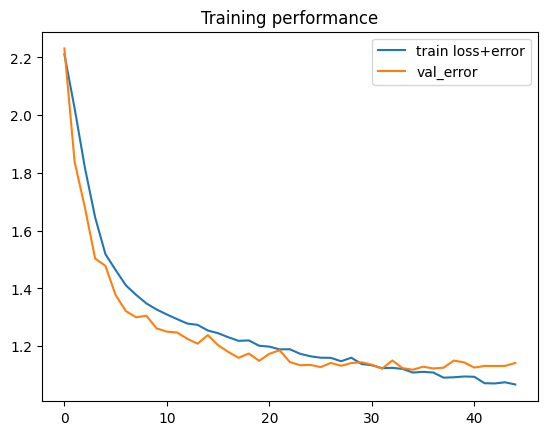

In [ ]:
# Show loss curves
plt.figure();
plt.title('Training performance');
plt.plot(history.epoch, history.history['loss'], label='train loss+error');
plt.plot(history.epoch, history.history['val_loss'], label='val_error');
plt.legend();

Se evidencia que la validación de error sigue el mismo comportamiento que el error de entrenamiento, aunque con una gran variación al inicio pero esto se debe a que el modelo inicialmente se está entrenando y no se tiene mucha información, a medida que se avanza se va ajustando conforme obtiene más información. Sin embargo se notan algunos picos los cuales denotan que el modelo puede estar sobreajustado, se adapta demasiado a los datos de entrenamiento y pierde su capacidad de generalización.

# Matriz de confusión

Una matriz de confusión es una excelente manera de ver dónde tuvo problemas el modelo (red neuronal). Traza el número de veces que el modelo predijo una modulación versus la modulación real (predicha versus verdadera).

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

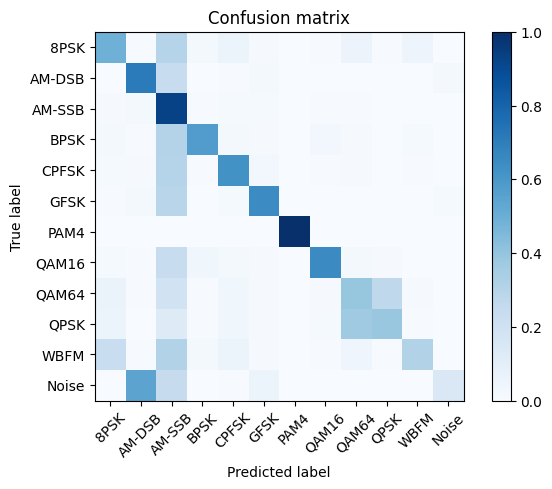

In [ ]:
# Plot confusion matrix
#test_Y_hat = model.predict(X_test, batch_size=batch_size)
classes=mods
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    #k = int(np.argmax(test_Y_hat[i,:]))
    k = int(np.argmax(y_predict[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



Analizando la matriz de confusión se observa como las siguientes modulaciones presentan mejores estimaciones: AM-SSB, AM-DSB, GFSK, CPFSK, PAM4, QAM16 y QPSK.

Evalúe el modelo en términos de $SNR$ y su precisión para cada modulación (a continuación se muestra un código de muestra para evaluar sus modelos)

112/112 [==============================] - 1s 3ms/step
Overall Accuracy for SNR -20: 0.16736518580609108
113/113 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -18: 0.17252838548878427
115/115 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -16: 0.1735446843399836
114/114 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -14: 0.18570640176600442
115/115 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -12: 0.21522453450164294
116/116 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -10: 0.27129679869777534
111/111 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -8: 0.39722929035906135
112/112 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -6: 0.5463196193674783
112/112 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -4: 0.6394083170527491
114/114 [==============================] - 0s 2ms/step
Overal

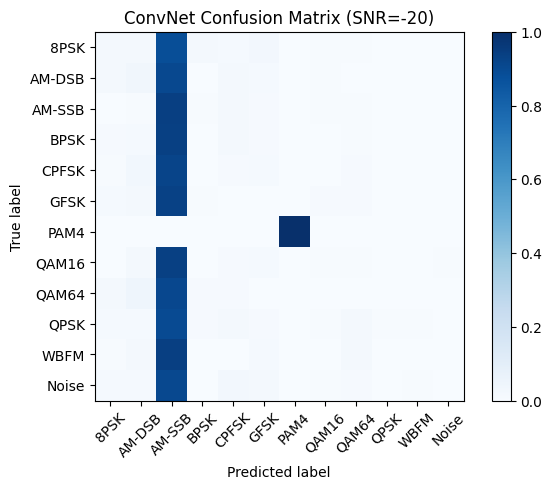

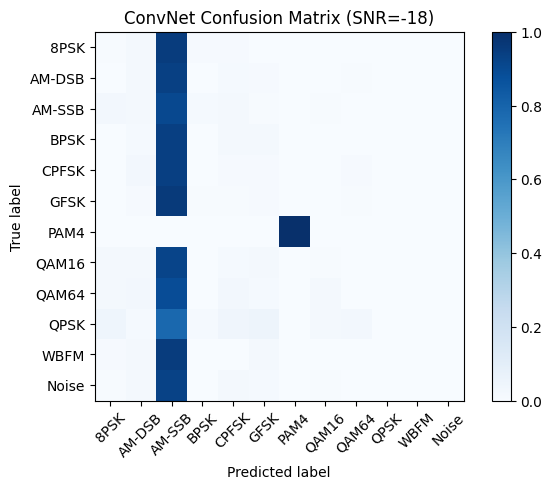

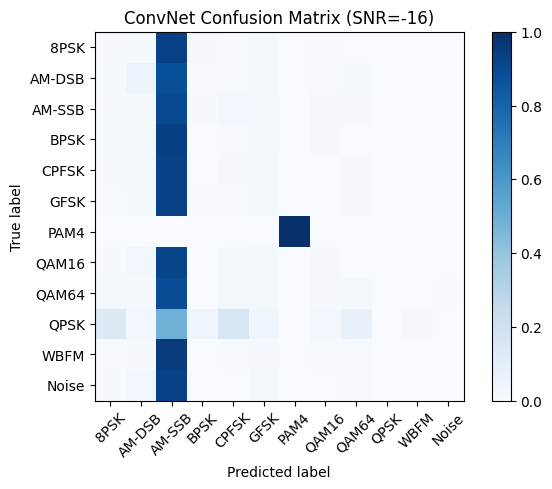

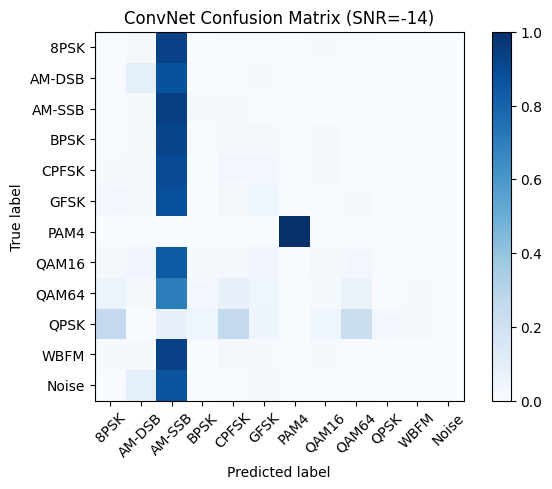

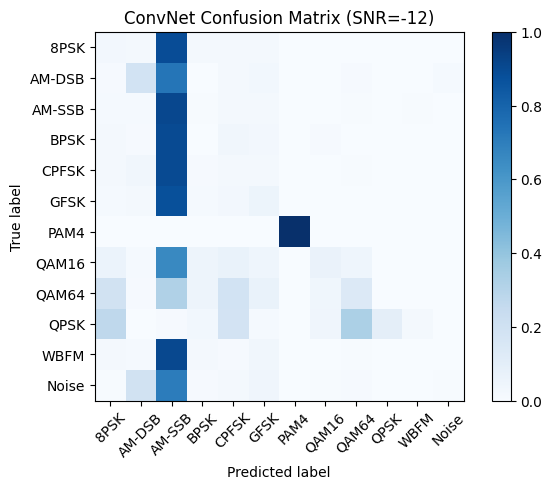

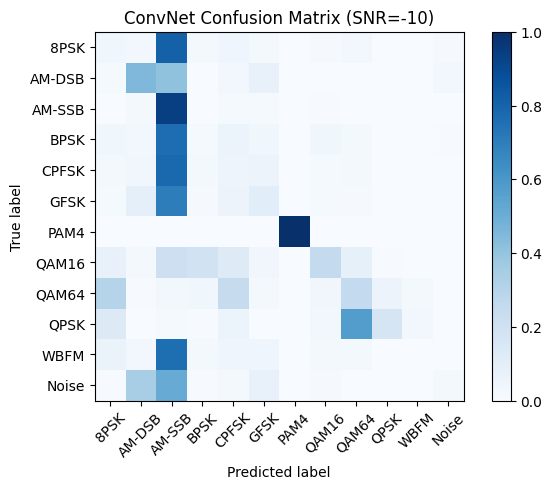

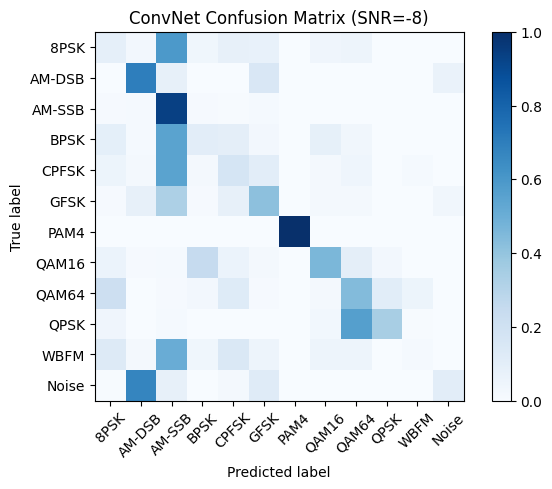

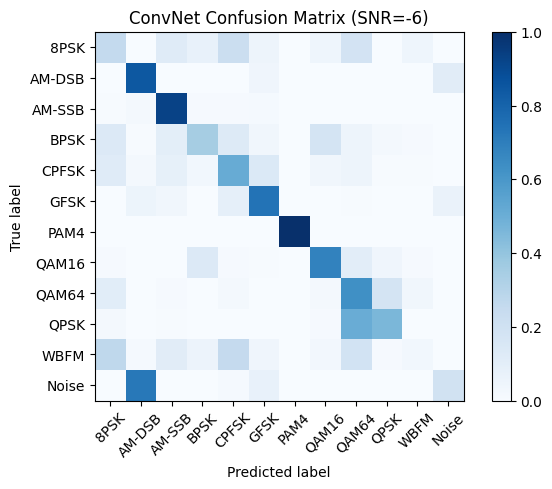

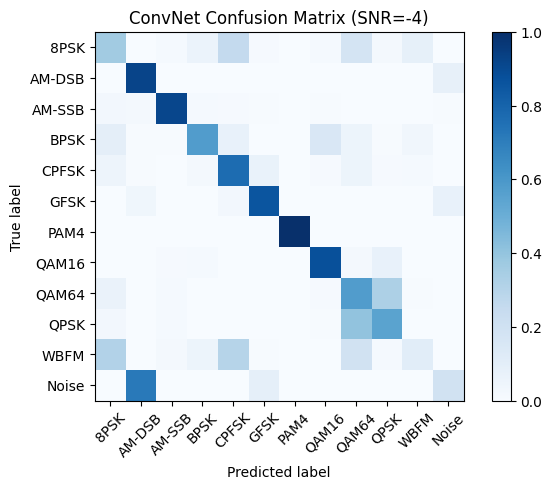

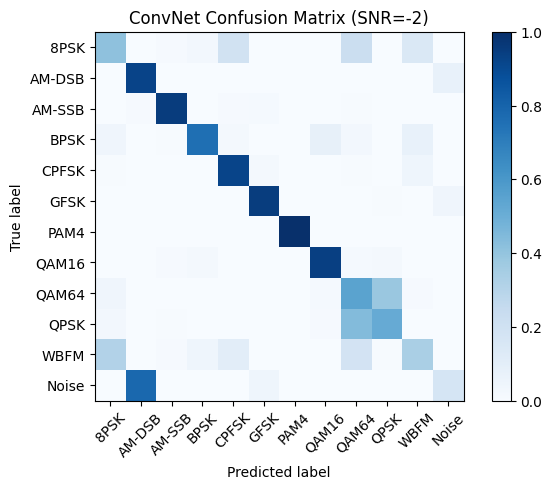

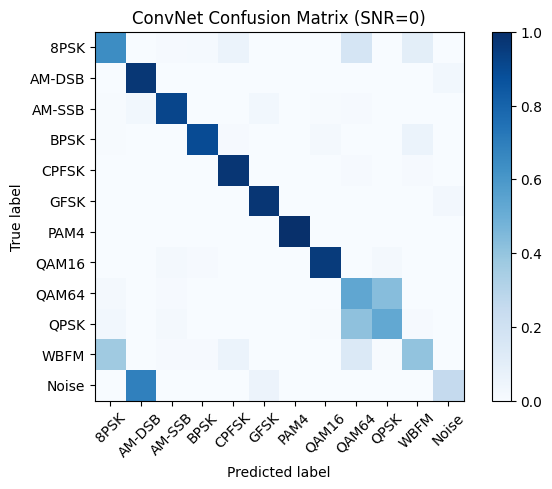

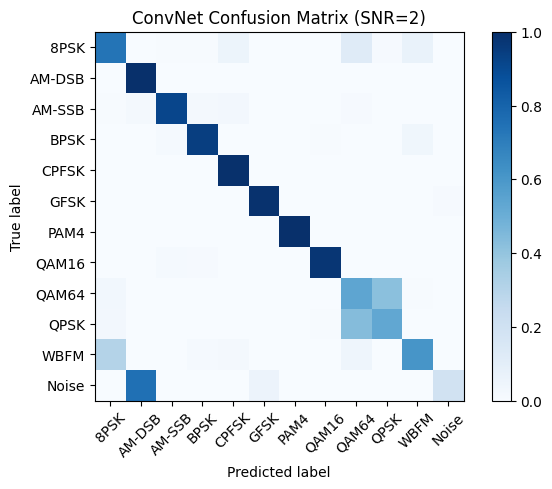

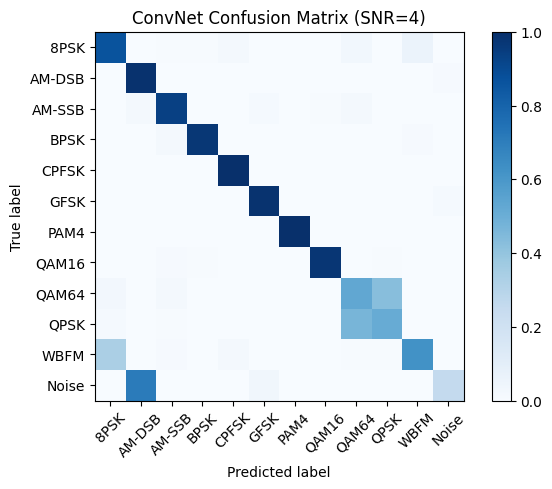

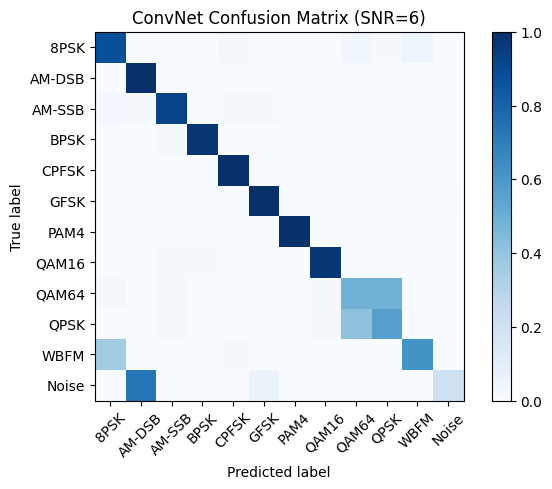

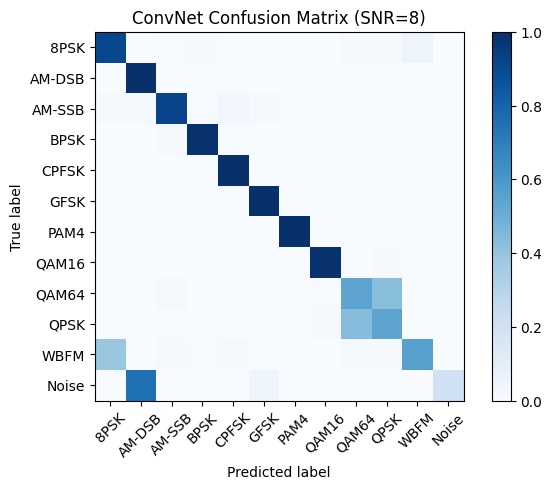

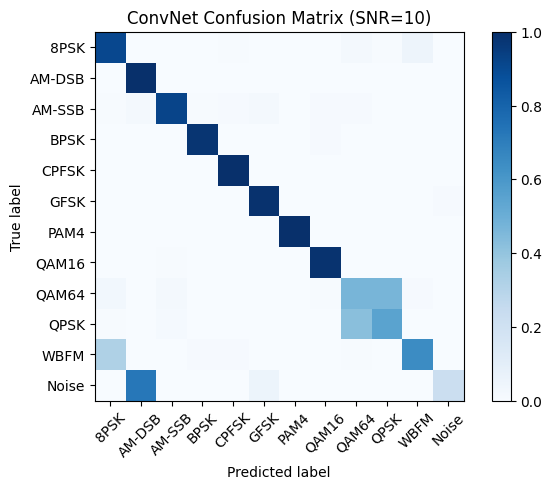

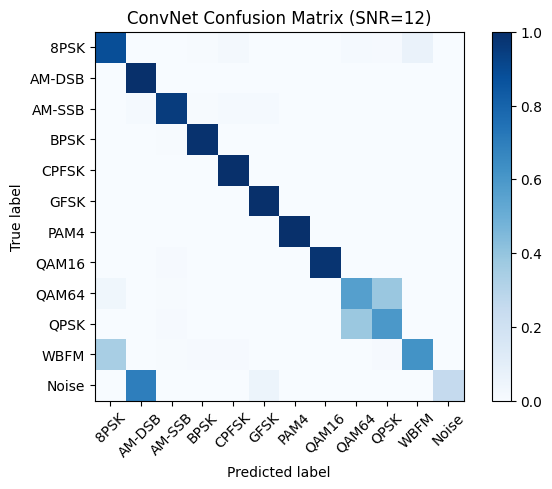

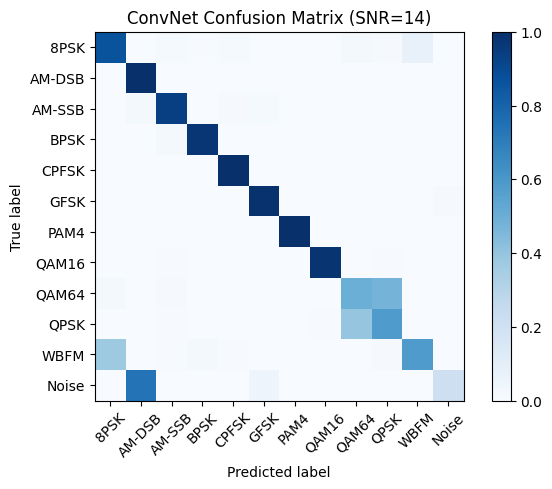

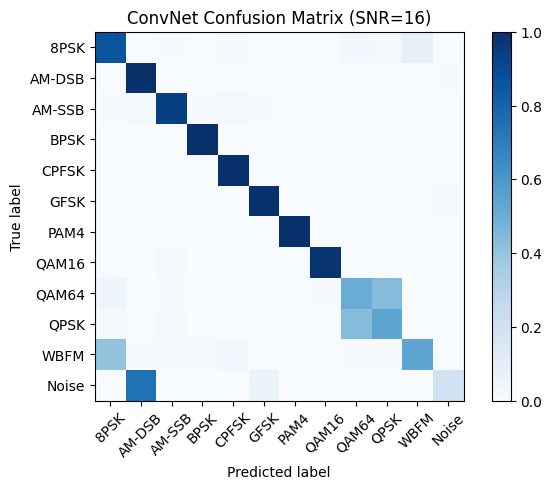

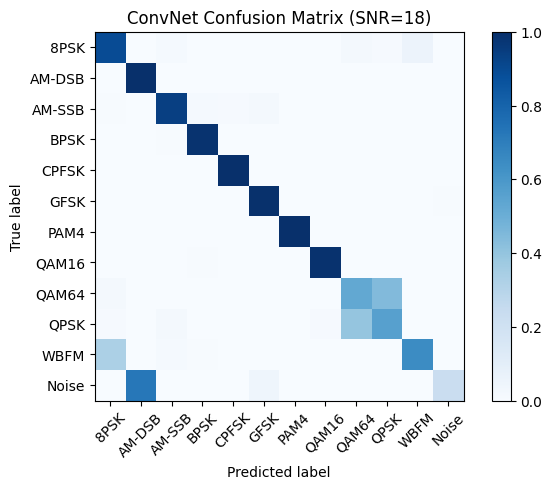

In [ ]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: int(lbl[x][1]), test_idx)
    test_S = []
    for i in test_SNRs:
      test_S.append(i)
    test_S = np.array(test_S)
    test_X_i = X_test[np.where(test_S == snr)]
    test_Y_i = Y_test[np.where(test_S == snr)]

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy for SNR {}: {}".format(snr, cor / (cor+ncor)))
    acc[snr] = 1.0*cor/(cor+ncor)


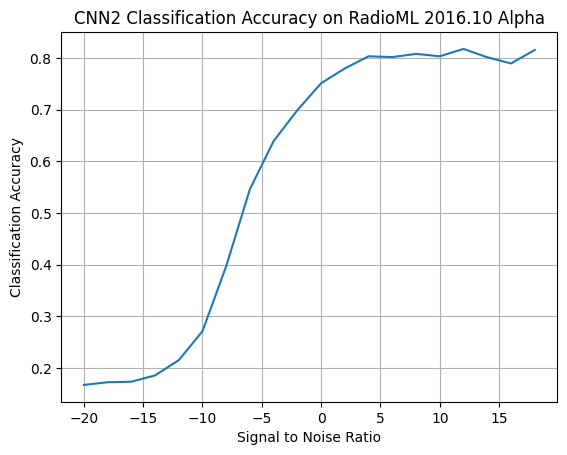

In [ ]:
# Plot accuracy curve

plt.plot(snrs, list(map(lambda x: acc[x], snrs)));
plt.xlabel("Signal to Noise Ratio");
plt.ylabel("Classification Accuracy");
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha");
plt.grid()
plt.show()

## Conclusiones

* La introducción de no linealidad mediante capas de activación permite a las redes aprender relaciones complejas en los datos, mejorando su capacidad de adaptación y rendimiento.
* El tamaño del kernel en las redes neuronales convolucionales (CNN) es un aspecto fundamental que influye en la capacidad del modelo para capturar y reconocer patrones en datos de entrada. El kernel en las CNN, se refiere a la matriz que se desliza sobre la entrada para realizar operaciones de convolución. Un tamaño de kernel más grande permite que la red examine áreas más extensas de la entrada. Además pueden ser más robustos ante variaciones en los datos de entrada, lo que contribuye a una mayor generalización del modelo. Esto significa que el modelo es capaz de realizar predicciones precisas incluso en datos que no ha visto antes, lo que da como resultado una mejor capacidad de adaptación a diferentes escenarios.
* La matriz de confusión proporciona una visión detallada de cómo el modelo clasifica diferentes clases, identificando áreas de confusión y ofreciendo oportunidades para mejorar la precisión. De esta se derivan métricas como precisión, recall, F1-score, entre otros, que proporcionan una comprensión detallada del rendimiento del modelo. En el trabajo se evidencian algunas clases con bajo recall dificultando reconocer detectar patrones. Ademas el recall y el F1-Score deben estar equilibrados para un rendimiento óptimo.
* El tamaño del paso en convoluciones afecta la resolución espacial y la velocidad de entrenamiento del modelo. Strides más grandes pueden reducir la resolución y ralentizar la convergencia del modelo.
* Considerar el equilibrio de clases y la complejidad del modelo son aspectos cruciales en el desarrollo y desempeño de los modelos de aprendizaje automático, esto teniendo en cuenta que algunas pueden presentar alto o bajo desempeño.
* La aplicación de estrategias como el "Early stopping" puede evitar el sobreajuste al detener el entrenamiento tempranamente, contribuyendo a un mejor rendimiento.
